# Train a Faster RCNN to detect words in images

In this notebook it is displayed the process of training a model to specialize it into the task of word detection in a document. The process is segmented in the following steps:

1. Environment configuration
2. Data normalitzation and dataset setup
3. Load out of the box model and evaluate it previous to the trainning
4. Training the model
5. Trained model Evaluation
6. Finish project

## 1. Environment configuration

First, we installed the necessary dependencies and configured the environment.

In [ ]:
!pip install ultralytics opencv-python tqdm
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

### Imports and code requirements

In [ ]:
import os
import json
import shutil
from pathlib import Path
import requests
from tqdm import tqdm
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from google.colab import drive
import zipfile
import subprocess
import time
import yaml
from collections import defaultdict
from PIL import Image, ImageDraw
import random
import torch
import matplotlib.pyplot as plt

print(f"GPU disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 10]

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
GPU disponible: True
GPU: NVIDIA L4


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 2. Data normalitzation and dataset setup

### Extraction of annotations zip

In [ ]:
def extract_zip(zip_file, extract_dir, images_source_dir):
    """Extrae archivos del zip que contengan en su nombre el nombre base de un
    .jpg en images_source_dir, ignorando el sufijo '_ori'

      Se almacenan las anotaciones extraidas del zip en 'extract_dir'
    """

    print(f"Extrayendo {zip_file}...")
    try:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            files = zip_ref.namelist()

            # Obtener los nombres base de los .jpg, eliminando el sufijo '_ori' si está presente
            jpg_basenames = set([
                img_path.stem.replace('_ori', '')
                for img_path in Path(images_source_dir).glob('*.jpg')
            ])
            print(f"JPG BASENAMES (sin '_ori'): {jpg_basenames}")

            for file in files:
                file_stem = Path(file).stem
                for jpg_name in jpg_basenames:
                    if jpg_name in file_stem:
                        print(f"Copiando {file} a {extract_dir} porque contiene '{jpg_name}'")
                        zip_ref.extract(file, extract_dir)
                        break  # Ya se encontró una coincidencia
    except zipfile.BadZipFile:
        print(f"Error: {zip_file} no es un archivo zip válido")
        raise



In [ ]:
# Extract annotations zip
drive.mount('/content/drive', force_remount=True)
dataset_dir = Path('/content/drive/MyDrive/yoloDocBankPoc/Annotations')
annotations_zip = Path('/content/drive/MyDrive/DocBank_500K_txt.zip')
images_source_dir = Path('/content/drive/MyDrive/SmallSmallBatch')

dataset_dir.mkdir(parents=True, exist_ok=True)

extract_zip(annotations_zip, dataset_dir, images_source_dir)

Mounted at /content/drive


### Preparation of the dataset

In [ ]:
def prepare_docbank():
    """Prepara el dataset DocBank para YOLOv8 copiando imágenes y anotaciones a subcarpetas nuevas."""

    # Directorios base
    dataset_dir = Path('/content/drive/MyDrive/YOLO_v8')
    images_source_dir = dataset_dir / 'DocBank_subset_10k'
    annotations_dir = dataset_dir / 'DocBank_subset_10k_txt'

    images_dir = dataset_dir / 'images'
    labels_dir = dataset_dir / 'transformed_labels'

    # Crear estructura de directorios sin modificar archivos originales
    for split in ['train', 'val', 'test']:
        (images_dir / split).mkdir(parents=True, exist_ok=True)
        (labels_dir / split).mkdir(parents=True, exist_ok=True)

    print(list(images_source_dir.iterdir())[:5])

    # Obtener imágenes .jpg
    all_image_files = list(images_source_dir.glob('*.jpg'))
    np.random.shuffle(all_image_files)
    print(f"Total de imagenes: {len(all_image_files)}")

    # Crear splits
    train_size = int(0.8 * len(all_image_files))
    val_size = int(0.1 * len(all_image_files))

    train_files = all_image_files[:train_size]
    val_files = all_image_files[train_size:train_size + val_size]
    test_files = all_image_files[train_size + val_size:]

    splits = {
        'train': train_files,
        'val': val_files,
        'test': test_files
    }

    # Procesar cada split
    for split_name, image_files in splits.items():
        print(f"📁 Procesando split: {split_name}")
        for img_file in tqdm(image_files):
            raw_stem = img_file.stem
            base_name = raw_stem.replace('_ori', '')

            # Copiar imagen con su nombre original
            dest_img_path = images_dir / split_name / img_file.name
            shutil.copy(img_file, dest_img_path)

            # Buscar anotación correspondiente
            txt_file = annotations_dir / f"{base_name}.txt"
            if not txt_file.exists():
                print(f"⚠️ No hay anotación para: {base_name}")
                continue

            # Copiar anotación directamente ya que está en formato YOLO
            dest_label_path = labels_dir / split_name / f"{base_name}.txt" #raw_stem o base_name.... ? testear.
            shutil.copy(txt_file, dest_label_path)

    print("✅ ¡Dataset preparado con copias seguras!")


In [ ]:
# Paso 1: Preparar el dataset
prepare_docbank()

[PosixPath('/content/drive/MyDrive/YOLO_v8/DocBank_subset_10k/159.tar_1412.0050.gz_Kazimierz2014-2_10_ori.jpg'), PosixPath('/content/drive/MyDrive/YOLO_v8/DocBank_subset_10k/181.tar_1511.03215.gz_paper_4_ori.jpg'), PosixPath('/content/drive/MyDrive/YOLO_v8/DocBank_subset_10k/206.tar_1807.06979.gz_icm_20_ori.jpg'), PosixPath('/content/drive/MyDrive/YOLO_v8/DocBank_subset_10k/85.tar_1407.1837.gz_23643_22_ori.jpg'), PosixPath('/content/drive/MyDrive/YOLO_v8/DocBank_subset_10k/152.tar_1608.03981.gz_dncnn_4_ori.jpg')]
Total de imagenes: 10000
📁 Procesando split: train


  0%|          | 34/8000 [01:04<3:29:46,  1.58s/it]

⚠️ No hay anotación para: 116.tar_1409.3036.gz_Permanental_polynomials_of_skew_adjacency_matrices_ofented_graphs_7


  4%|▍         | 347/8000 [10:13<2:57:38,  1.39s/it]

⚠️ No hay anotación para: 121.tar_1606.08854.gzonasouth_firstlook_0


 68%|██████▊   | 5458/8000 [2:35:14<59:52,  1.41s/it]  

⚠️ No hay anotación para: 211.tar_1807.08734.gz_Fitgins_7


100%|██████████| 8000/8000 [3:44:57<00:00,  1.69s/it]


📁 Procesando split: val


100%|██████████| 1000/1000 [27:14<00:00,  1.63s/it]


📁 Procesando split: test


 30%|██▉       | 299/1000 [08:05<16:34,  1.42s/it]

⚠️ No hay anotación para: 79.tar_1803.08674.gzginal_23


100%|██████████| 1000/1000 [27:09<00:00,  1.63s/it]

✅ ¡Dataset preparado con copias seguras!


In [ ]:
import os
import re


# Directorios base
dataset_dir = Path('/content/drive/MyDrive/YOLO_v8')
labels_dir = dataset_dir / 'transformed_labels'

# Overwrite original files or write filtered ones with prefix
OVERWRITE = True

# Regex for English words (letters + optional hyphens/apostrophes)
WORD_REGEX = re.compile(r"^[A-Za-z]+(?:[-'][A-Za-z]+)*$")

def is_valid_english_word(token):
    return (
        len(token) >= 3 and
        bool(WORD_REGEX.fullmatch(token))
    )

def filter_annotation_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    filtered_lines = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) < 10:
            print(f"Skipping malformed line in {file_path}: {line.strip()}")
            continue

        token = parts[0]
        if is_valid_english_word(token):
            filtered_lines.append(line)
        else:
            print(f"❌ Discarded token: '{token}' in file: {file_path}")

    return filtered_lines


def process_all_txt_files(root_path):
    for dirpath, dirnames, filenames in os.walk(root_path):
        for filename in filenames:
            if filename.endswith(".txt"):
                full_path = os.path.join(dirpath, filename)
                filtered = filter_annotation_file(full_path)

                if OVERWRITE:
                    with open(full_path, 'w', encoding='utf-8') as f:
                        f.writelines(filtered)
                else:
                    new_filename = f"filtered_{filename}"
                    new_path = os.path.join(dirpath, new_filename)
                    with open(new_path, 'w', encoding='utf-8') as f:
                        f.writelines(filtered)

# Run it
process_all_txt_files(labels_dir)


Streaming output truncated to the last 5000 lines.
❌ Discarded token: '|' in file: /content/drive/MyDrive/YOLO_v8/transformed_labels/test/240.tar_1710.08159.gz_Duffing-ter_24.txt
❌ Discarded token: '|' in file: /content/drive/MyDrive/YOLO_v8/transformed_labels/test/240.tar_1710.08159.gz_Duffing-ter_24.txt
❌ Discarded token: 'ψ(t)' in file: /content/drive/MyDrive/YOLO_v8/transformed_labels/test/240.tar_1710.08159.gz_Duffing-ter_24.txt
❌ Discarded token: 'λ2' in file: /content/drive/MyDrive/YOLO_v8/transformed_labels/test/240.tar_1710.08159.gz_Duffing-ter_24.txt
❌ Discarded token: 'u−(t)' in file: /content/drive/MyDrive/YOLO_v8/transformed_labels/test/240.tar_1710.08159.gz_Duffing-ter_24.txt
❌ Discarded token: '2' in file: /content/drive/MyDrive/YOLO_v8/transformed_labels/test/240.tar_1710.08159.gz_Duffing-ter_24.txt
❌ Discarded token: 'u−(t)' in file: /content/drive/MyDrive/YOLO_v8/transformed_labels/test/240.tar_1710.08159.gz_Duffing-ter_24.txt
❌ Discarded token: '+' in file: /content/

In [ ]:
#Optional script
#transforms all files in a folder and strips the "_ori" in their names

root_dir = "/content/drive/MyDrive/YOLO_v8/images"

for dirpath, dirnames, filenames in os.walk(root_dir):
    for fname in filenames:
        if fname.endswith("_ori.jpg"):
            old_path = os.path.join(dirpath, fname)
            new_name = fname.replace("_ori", "")
            new_path = os.path.join(dirpath, new_name)
            os.rename(old_path, new_path)
            print(f"Renamed: {old_path} -> {new_path}")


## 3. Load out of the box model and evaluate it previous to the trainning

In [ ]:
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
from torchvision.models.detection.roi_heads import RoIHeads
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.models.detection.faster_rcnn import TwoMLPHead, FastRCNNPredictor
from torchvision.ops import misc as misc_nn_ops
from torchvision.ops import MultiScaleRoIAlign
import torch.nn as nn
from collections import OrderedDict


class FasterRCNN(nn.Module):
    def __init__(self, backbone, rpn_pre_nms_top_n_train=3000, rpn_pre_nms_top_n_test=2000, #Updated to 3000 taking into consideration the max amount of words per page
                 rpn_post_nms_top_n_train=3000, rpn_post_nms_top_n_test=2000,
                 rpn_nms_thresh=0.7,
                 rpn_fg_iou_thresh=0.7, rpn_bg_iou_thresh=0.3,
                 rpn_batch_size_per_image=256, rpn_positive_fraction=0.5,
                 box_score_thresh=0.05, box_nms_thresh=0.5, box_detections_per_img=200,
                 box_fg_iou_thresh=0.5, box_bg_iou_thresh=0.5,
                 box_batch_size_per_image=512, box_positive_fraction=0.25,
                 bbox_reg_weights=None, num_classes=3):
                  #num_classes used to be 91... testing
        super().__init__()
        # First, set the backbone that we will use to extract the feature maps
        self.backbone = backbone

        out_channels = backbone.out_channels
        anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
        aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)

        # Declare the anchor generator of the Region Proposal Network (RPN)
        rpn_anchor_generator = AnchorGenerator(
            anchor_sizes, aspect_ratios
        )

        # Declare the Head of the RPN that will classify the proposals
        rpn_head = RPNHead(
            out_channels, rpn_anchor_generator.num_anchors_per_location()[0]
        )
        rpn_pre_nms_top_n = {"training": rpn_pre_nms_top_n_train, "testing": rpn_pre_nms_top_n_test}
        rpn_post_nms_top_n = {"training": rpn_post_nms_top_n_train, "testing": rpn_post_nms_top_n_test}

        # Create the RPN combining the anchor generator and the head
        self.rpn = RegionProposalNetwork(
            rpn_anchor_generator, rpn_head,
            rpn_fg_iou_thresh, rpn_bg_iou_thresh,
            rpn_batch_size_per_image, rpn_positive_fraction,
            rpn_pre_nms_top_n, rpn_post_nms_top_n, rpn_nms_thresh)

        # ROI Align
        box_roi_pool = MultiScaleRoIAlign(
            featmap_names=['0', '1', '2', '3'],
            output_size=7,
            sampling_ratio=2)

        resolution = box_roi_pool.output_size[0]
        representation_size = 1024

        # Simple Head made of 2 Fully Connected layers
        box_head = None #we will set them in the exercises

        representation_size = 1024

        # Predictor with 2 outputs (scores and Bounding Boxes deltas)
        box_predictor = None #we will set them in the exercises

        # Module that combines the last modules to compute the prediction of every box and match
        # targets and proposalt in training
        self.roi_heads = RoIHeads(
            # Box
            box_roi_pool, box_head, box_predictor,
            box_fg_iou_thresh, box_bg_iou_thresh,
            box_batch_size_per_image, box_positive_fraction,
            bbox_reg_weights,
            box_score_thresh, box_nms_thresh, box_detections_per_img)
        min_size=800
        max_size=1333
        self.image_mean = [0.485, 0.456, 0.406]
        self.image_std = [0.229, 0.224, 0.225]

        # Module that does the correct data augmentation
        self.transform = GeneralizedRCNNTransform(min_size, max_size, self.image_mean, self.image_std)

    def forward(self, images, targets=None):
      if self.training and targets is None:
          raise ValueError("In training mode, targets should be passed")

      original_image_sizes = [img.shape[-2:] for img in images]

      images, targets = self.transform(images, targets)
      features = self.backbone(images.tensors)
      if isinstance(features, torch.Tensor):
          features = OrderedDict([('0', features)])

      proposals, proposal_losses = self.rpn(images, features, targets)
      detections, detector_losses = self.roi_heads(features, proposals, images.image_sizes, targets)

      losses = {}
      losses.update(detector_losses)
      losses.update(proposal_losses)

      if self.training:
          return losses  # <--- only return losses
      else:
          detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)
          return detections,losses


In [ ]:
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

backbone = resnet_fpn_backbone('resnet18', pretrained=True)
model = FasterRCNN(backbone, num_classes=3)  # 2 classes + background
print(type(model))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f370

<class '__main__.FasterRCNN'>


In [ ]:
#Checking if we have batch normalization layers
def has_batchnorm(model):
    return any(isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)) for m in model.modules())

print(has_batchnorm(model))


False


In [ ]:
class TwoMLPHead(nn.Module):
    """
    Standard heads for FPN-based models

    Arguments:
        in_size (int): number of inputs
        representation_size (int): size of the intermediate representation
    """

    def __init__(self, in_size, representation_size):
        super(TwoMLPHead, self).__init__()

        self.fc6 = nn.Linear(in_size, representation_size)
        self.fc7 = nn.Linear(representation_size, representation_size)

    def forward(self, x):
        # Flatten the input tensor: [batch, 256, 7, 7] -> [batch, 256*7*7]
        x = x.flatten(start_dim=1)

        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))

        return x

In [ ]:
class FastRCNNPredictor(nn.Module):
    """
    Standard classification + bounding box regression layers
    for Fast R-CNN.

    Arguments:
        in_size (int): number of input channels
        num_classes (int): number of output classes (including background)
    """

    def __init__(self, in_size, num_classes):
        super(FastRCNNPredictor, self).__init__()
        self.cls_score = nn.Linear(in_size, num_classes)
        self.bbox_pred = nn.Linear(in_size, 4 * num_classes)

    def forward(self, x):
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)

        return scores, bbox_deltas

In [ ]:
in_size = 256*7*7
representation_size = 1024
num_classes = 3 #used to be 91
model.roi_heads.box_head = TwoMLPHead(in_size, representation_size)
model.roi_heads.box_predictor = FastRCNNPredictor(representation_size, num_classes)

In [ ]:
model.to(device).eval();
print(type(model))

<class '__main__.FasterRCNN'>


In [ ]:
def show_image(pil_im):
    plt.imshow(np.asarray(pil_im))

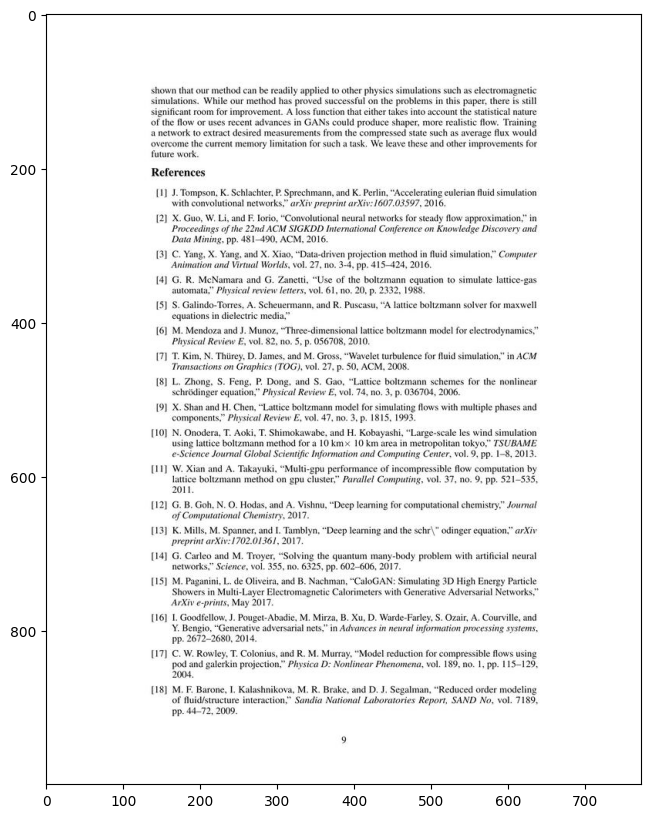

In [ ]:
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
import torch
from ultralytics import YOLO

images_path = Path('/content/drive/MyDrive/YOLO_v8/images/train')

jpg_files = list(images_path.glob('*.jpg'))

if not jpg_files:
    raise FileNotFoundError(f"No se encontraron archivos .jpg en {images_path}")

random_image_path = random.choice(jpg_files)

im = Image.open(random_image_path).convert('RGB')
transform = Compose([
    Resize((640, 640)),  # Ensure size is divisible by 32
    ToTensor()
])
show_image(im)

In [ ]:
from urllib.request import urlretrieve

yolo_labels = ['abstract',
               'author',
               'caption',
               'equation',
               'figure',
               'footer',
               'list',
               'paragraph',
               'reference',
               'section',
               'table',
               'title']

a = urlretrieve("https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt", "labels.txt")

with open("labels.txt", "r") as f:
    for line in f.readlines():
        yolo_labels.append(line.replace("\n", ""))

### Preprocessing transformations

In [ ]:
from torchvision.transforms.functional import to_tensor



#We convert the im (image) to a pytorch tensor for the model
x = to_tensor(im).to(device)
targets = None

print("Before transform:", x.min(), x.max(), x.mean(), x.std())

transformed, _ = model.transform([x], targets)

print("After transform:", transformed.tensors[0].min(), transformed.tensors[0].max(),
      transformed.tensors[0].mean(), transformed.tensors[0].std())

Before transform: tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(0.9427, device='cuda:0') tensor(0.1704, device='cuda:0')
After transform: tensor(-2.1064, device='cuda:0') tensor(2.6400, device='cuda:0') tensor(2.1401, device='cuda:0') tensor(0.7380, device='cuda:0')


In [ ]:
transformed, _ = model.transform([x], targets)

### Feature Extraction

In [ ]:
feature_maps = model.backbone(transformed.tensors)
print({k: v.shape for k, v in feature_maps.items()})

{'0': torch.Size([1, 256, 264, 200]), '1': torch.Size([1, 256, 132, 100]), '2': torch.Size([1, 256, 66, 50]), '3': torch.Size([1, 256, 33, 25]), 'pool': torch.Size([1, 256, 17, 13])}


In [ ]:
feature_maps['0']

tensor([[[[ 5.2930e-01, -1.0306e-01, -7.7520e-02,  ..., -5.9110e-01, -5.1867e-01,  9.1090e-01],
          [ 3.9330e-01, -9.4919e-01, -8.5089e-01,  ..., -1.2927e+00, -5.6779e-01,  2.7822e-02],
          [-7.8167e-02, -1.2755e+00, -9.8801e-01,  ..., -1.6583e+00, -1.0728e+00, -9.1312e-02],
          ...,
          [-6.1668e-01, -8.4868e-01, -9.6996e-01,  ..., -4.8271e-01,  3.3776e-02,  6.7890e-01],
          [-8.7422e-01, -1.3277e+00, -1.1863e+00,  ..., -9.0564e-01, -7.9245e-01, -5.3969e-02],
          [-9.1272e-01, -1.2911e+00, -1.0825e+00,  ..., -1.0306e+00, -1.0879e+00, -9.4305e-01]],

         [[-7.4356e-01, -1.5636e+00, -1.7374e+00,  ..., -1.7127e+00, -2.1779e+00, -1.6337e+00],
          [-1.3884e+00, -9.0491e-01, -9.6937e-01,  ..., -8.2580e-01, -1.3916e+00, -1.5452e+00],
          [-1.5240e+00, -1.3307e+00, -1.6810e+00,  ..., -1.0458e+00, -1.6615e+00, -1.4988e+00],
          ...,
          [-5.6385e-03, -2.2938e-01, -7.3026e-01,  ..., -2.2583e-01, -5.8440e-01, -1.0331e+00],
        

### Region proposal

In [ ]:
proposals, proposal_losses = model.rpn(transformed, feature_maps, targets)
proposals[0].shape


#We get:
#proposals: a list of tensors, one per image in the batch
#Each tensor contains N bounding boxes proposed by the RPN



torch.Size([2000, 4])

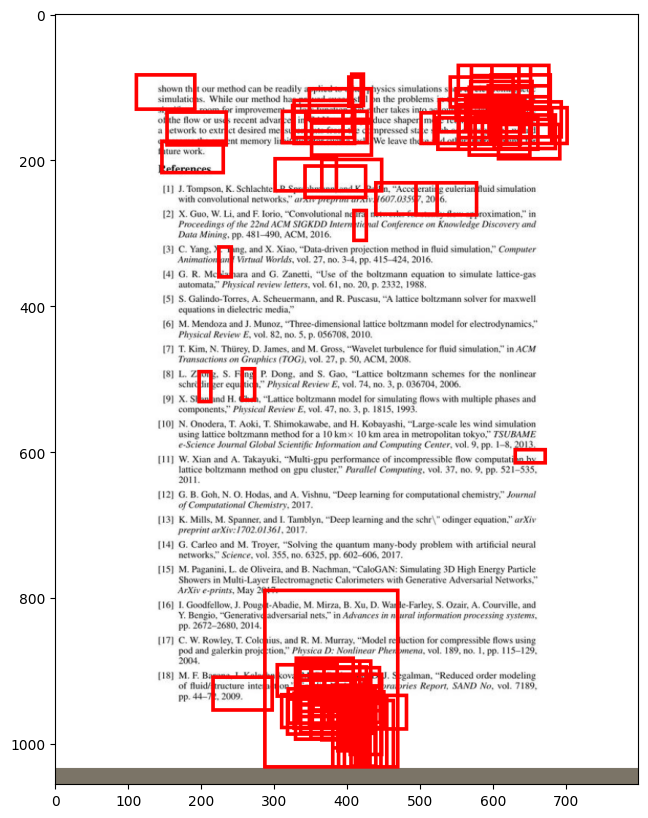

In [ ]:
'''
from torchvision.transforms.functional import to_pil_image

aux = transformed.tensors[0].cpu()
aux = aux*torch.tensor(model.image_std).reshape(3,1,1)+torch.tensor(model.image_mean).reshape(3,1,1)
transformed_im = to_pil_image(aux)
draw = ImageDraw.Draw(transformed_im)
for p in proposals[0][:2]:
    coords = p.cpu().detach().tolist()
    draw.rectangle(coords, width=5, outline="red")
show_image(transformed_im)

#Here we can:
#Debug whether the RPN is proposing useful object locations
#Understand how the model sees the scene before "classification"
#(Classification will not really be needed)
'''

from torchvision.transforms.functional import to_pil_image
from PIL import ImageDraw
import torch

# Define ImageNet normalization values manually
image_mean = [0.485, 0.456, 0.406]
image_std = [0.229, 0.224, 0.225]

aux = transformed.tensors[0].cpu()
mean = torch.tensor(image_mean).reshape(3,1,1)
std = torch.tensor(image_std).reshape(3,1,1)

# De-normalize the image tensor
aux = aux * std + mean
aux = aux.clamp(0, 1)  # ensure values are in valid range

transformed_im = to_pil_image(aux)
draw = ImageDraw.Draw(transformed_im)

for p in proposals[0][:100]:
    coords = p.cpu().detach().tolist()
    draw.rectangle(coords, width=5, outline="red")

transformed_im.show()
show_image(transformed_im)


### ROI classifier and regressor

In [ ]:
import torch.nn.functional as F

In [ ]:
detections, detector_losses = model.roi_heads(feature_maps, proposals, transformed.image_sizes, targets)
detections = model.transform.postprocess(detections, transformed.image_sizes, [[im.height, im.width]])[0]

In [ ]:
print({k: v.shape for k, v in detections.items()})

{'boxes': torch.Size([200, 4]), 'labels': torch.Size([200]), 'scores': torch.Size([200])}


Number of yolo labels: 103
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
L

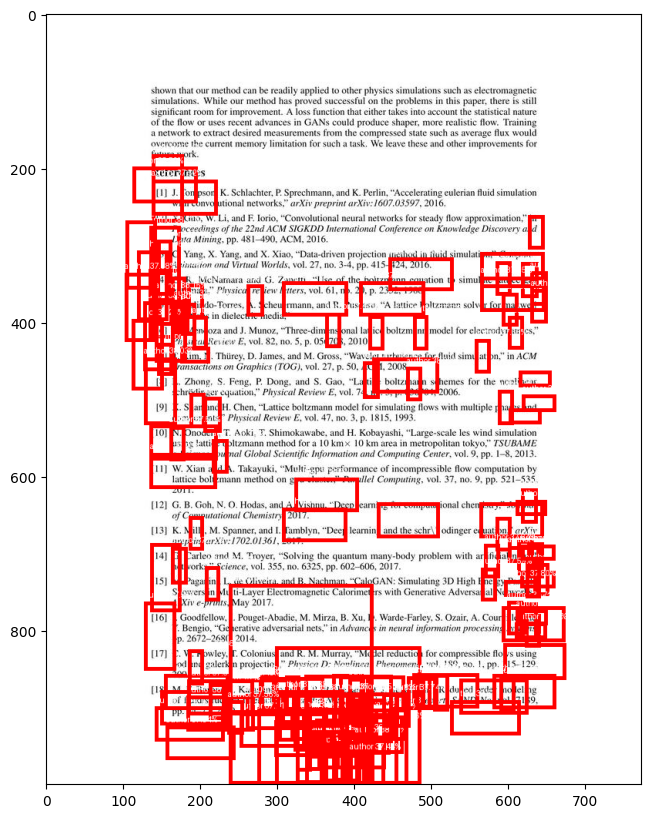

In [ ]:
import torchvision

iou_threshold = 0.4
scores_threshold = 0.1
keep_idx = torchvision.ops.nms(detections["boxes"], detections["scores"], iou_threshold)
boxes = [b for i, b in enumerate(detections["boxes"]) if i in keep_idx]
scores = [s for i, s in enumerate(detections["scores"]) if i in keep_idx]
labels = [l for i, l in enumerate(detections["labels"]) if i in keep_idx]

print(f"Number of yolo labels: {len(yolo_labels)}")
for label in labels:
    print("Label:", label.item())

draw = ImageDraw.Draw(im)
for box, score, label in zip(boxes, scores, labels):
    if score > scores_threshold:
        coords = box.cpu().tolist()
        draw.rectangle(coords, width=5,outline="red")
        text = f"{yolo_labels[label.item()]} {score*100:.2f}%"
        draw.text([coords[0], coords[1]-15], text)
show_image(im)


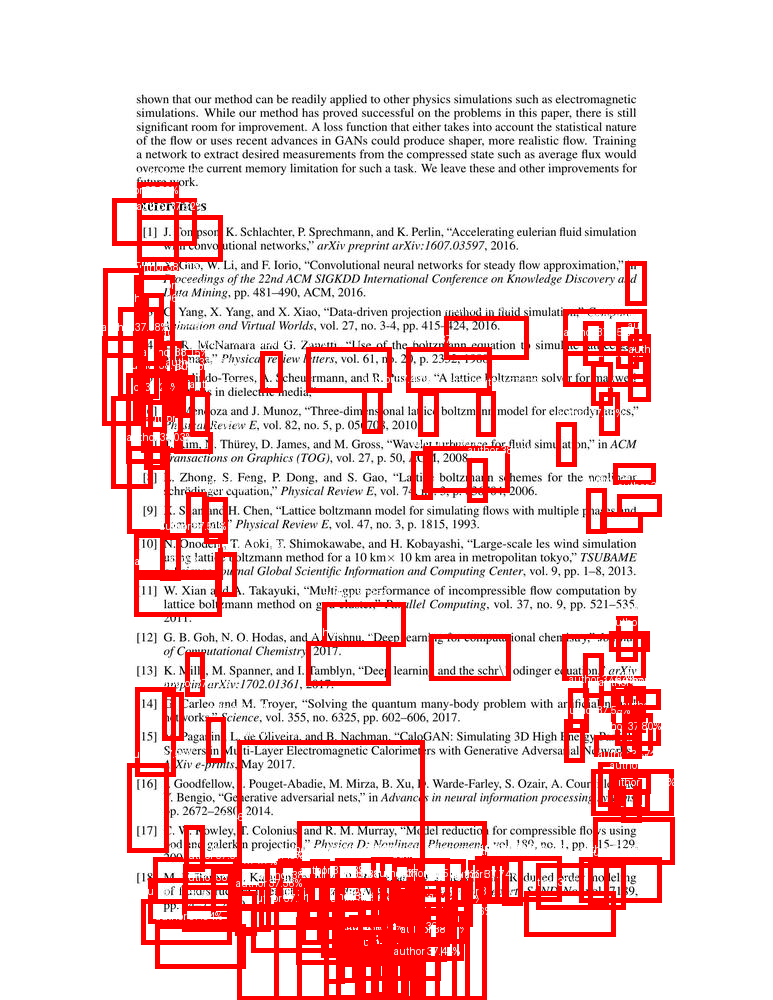

In [ ]:
im

## 4. Training the model

Now we will design the training loop

### Transfer Learning

As we could see, the model itself is not able to detect the words over the images. We will feed the model with the data of our dataset and train it to be able to detect

In [ ]:
import torch.optim as optim


num_classes = 13
#num_classes = 3

# get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# move model to training mode and device
model = model.train().to(device)

### Dataset class declaration

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import ToTensor
from PIL import Image
import os
from torch.utils.data import DataLoader

class DocBankDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, class_names, transforms=None):
        """
        images_dir: folder with images
        annotations_dir: folder with annotation txt files
        class_names: list of class names (e.g. ['abstract', 'author', ..., 'title'])
        transforms: torchvision transforms to apply on images and targets
        """
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transforms = transforms

        self.class_names = class_names
        self.class_to_idx = {c: i + 1 for i, c in enumerate(class_names)}  # class IDs start at 1
        # gather all image file names (without extension)
        self.image_files = sorted([
            f for f in os.listdir(images_dir)
            if f.lower().endswith(('.jpg', '.png', '.jpeg')) and
            os.path.exists(os.path.join(annotations_dir, os.path.splitext(f)[0] + ".txt"))
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
      img_name = self.image_files[idx]
      img_path = os.path.join(self.images_dir, img_name)
      image = Image.open(img_path).convert("RGB")
      img_width, img_height = image.size

      # Apply resize + ToTensor transforms
      if self.transforms:
          image = self.transforms(image)

      annot_path = os.path.join(self.annotations_dir, os.path.splitext(img_name)[0] + ".txt")

      #print(f"Loading image: {img_path}, annotation: {annot_path}")
      if not os.path.exists(annot_path):
        print(f"Annotation file not found for image {img_name}")
        # Option 1: Skip this sample (not ideal for DataLoader)
        # Option 2: Raise an error with a clear message
        raise FileNotFoundError(f"Annotation file not found: {annot_path}")

      boxes = []
      labels = []

      with open(annot_path, 'r') as f:
          for line in f:
              parts = line.strip().split('\t')
              if len(parts) < 10:
                  continue

              try:
                  xmin = float(parts[1])
                  ymin = float(parts[2])
                  xmax = float(parts[3])
                  ymax = float(parts[4])
                  label_str = parts[-1]

                  if label_str not in self.class_to_idx:
                      continue

                  if xmax <= xmin or ymax <= ymin:
                      continue  # skip invalid boxes


                  #2.Scale to actual image dimensions
                  #annotations were created within a 1000x1000 grid
                  #and image sizes vary, so we account for that here

                  scale_x = img_width / 1000
                  scale_y = img_height / 1000

                  xmin *= scale_x
                  xmax *= scale_x
                  ymin *= scale_y
                  ymax *= scale_y

                  boxes.append([xmin, ymin, xmax, ymax])
                  labels.append(self.class_to_idx[label_str])
              except Exception as e:
                  print(f"Warning: Skipping bad line in {annot_path}: {line}")
                  continue

      if len(boxes) == 0:
          # Return a dummy target to avoid crashing — or you can skip this sample in training loop
          boxes = torch.zeros((0, 4), dtype=torch.float32)
          labels = torch.zeros((0,), dtype=torch.int64)

      boxes = torch.as_tensor(boxes, dtype=torch.float32)
      labels = torch.as_tensor(labels, dtype=torch.int64)

      target = {
          "boxes": boxes,
          "labels": labels,
          "image_id": torch.tensor([idx]),
          "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
          "iscrowd": torch.zeros((len(boxes),), dtype=torch.int64),
      }

      if self.transforms:
          image, target = self.transforms(image, target)
      else:
          image = ToTensor()(image)

      return image, target





Here we declare the relative path were the data is stored in our drive

In [ ]:
#Base path
dataset_dir = Path('/content/drive/MyDrive/YOLO_v8')

# Device setup
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

class_names = ['abstract', 'author', 'caption', 'equation', 'figure', 'footer', 'list', 'paragraph', 'reference', 'section', 'table', 'title']

Using device: cuda


Here we create the Datasets that will be used on the train

In [ ]:
# Instantiate your DocBankDataset (make sure annotations path is correct)
train_dataset = DocBankDataset(
    images_dir= dataset_dir / "images/train",
    annotations_dir= dataset_dir / "transformed_labels/train",
    class_names=class_names,
    transforms=None  # you can add transforms if needed
)

# Validation dataset
val_dataset = DocBankDataset(
    images_dir= dataset_dir / "images/val",
    annotations_dir= dataset_dir / "transformed_labels/val",
    class_names=class_names,
    transforms=None
)

Here we create the data loaders required in the training

In [ ]:
# Define collate_fn to handle batches of varying-size targets
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
print(len(train_dataset))
print(len(val_dataset))

7997
1000


In [ ]:
# DataLoaders for batching
train_loader = DataLoader(
    train_dataset,
    batch_size=12,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=12,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

### Wandb declaration

In [ ]:
import wandb
#last lr was 0.005
#last batch size was 1
wandb.init(
    project="Computer_Vision",
    name="Fastercnn-Resnet18-10k-try-30-epochs",  # optional
    config={
        "epochs": 30,
        "batch_size": 12,
        "learning_rate": 0.003,
        "backbone":"resnet18_fpn",
        "dataset": "DocBank",
        "scheduler":"StepLR",
        "momentum": 0.9
    }
)


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: toninoguerarecasens (adriabuil-upc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


### Option 1: Train without metric track

Here we only train the model and keep track of its losses

In [ ]:
def print_gpu_report():
    print(f"[GPU MEM] Allocated: {torch.cuda.memory_allocated() / 1e6:.2f} MB")
    print(f"[GPU MEM] Cached   : {torch.cuda.memory_reserved() / 1e6:.2f} MB")

In [ ]:
"""Train the model using the DocBankDataset with FasterRCNN"""
import os
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR


os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

def train_model(epochs):
    """Train the model using the DocBankDataset with FasterRCNN"""

    model.to(device)

    # Optimizer #previous momentum was 0.9
    optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=0.0005)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR every 5 epochs by a factor of 0.1

    num_epochs = epochs
    wandb.watch(model, log="all", log_freq=10)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print_gpu_report()

        model.train()
        train_loss = 0.0

        train_loss_components = {k: 0.0 for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']}

        for i, (images, targets) in enumerate(train_loader):
            start_time = time.time()

            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Skip any batch with empty targets
            if any(len(t["boxes"]) == 0 for t in targets):
                print(f"Skipping empty target at step {i}")
                continue

            # Forward pass
            #loss_dict = model(images, targets)  # returns losses dict
            #_, loss_dict = model(images, targets)
            loss_dict = model(images, targets)  # no need for _

            # Sum losses
            losses = sum(loss for loss in loss_dict.values())
            train_loss += losses.item()

            for k in train_loss_components:
                if k in loss_dict:
                    train_loss_components[k] += loss_dict[k].item()

            # Backpropagation
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            torch.cuda.synchronize()  # ensure timing is accurate
            elapsed = time.time() - start_time

            if i % 60 == 0:
                loss_str = ", ".join([f"{k}: {v.item():.3f}" for k, v in loss_dict.items()])
                print(f"Step {i}/{len(train_loader)}: {loss_str}")

        # Calculate average training loss for the epoch
        train_loss /= len(train_loader)

        for k in train_loss_components:
                train_loss_components[k] /= len(train_loader)

        model.train()  # Needed to compute losses
        val_loss = 0.0
        val_loss_components = {k: 0.0 for k in
                              ['loss_classifier', 'loss_box_reg',
                                'loss_objectness', 'loss_rpn_box_reg']}

        with torch.no_grad():
            for i, (images, targets) in enumerate(val_loader):
                images = list(img.to(device) for img in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                if any(len(t["boxes"]) == 0 for t in targets):
                    continue

                loss_dict = model(images, targets)
                losses = sum(loss.item() for loss in loss_dict.values())
                val_loss += losses

                for k in val_loss_components:
                    if k in loss_dict:
                        val_loss_components[k] += loss_dict[k].item()

                if i % 10 == 0:
                    loss_str = ", ".join([f"{k}: {v.item():.3f}" for k, v in loss_dict.items()])
                    print(f"Validation Step {i}/{len(val_loader)}: {loss_str}")

        val_loss /= len(val_loader)
        for k in val_loss_components:
                    val_loss_components[k] /= len(val_loader)
        model.eval()  # Reset after validation

        scheduler.step()  # Step the scheduler

        # Metrics
        metrics = {
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "lr": optimizer.param_groups[0]['lr']
        }

        # Añadir pérdidas por componente
        for k, v in train_loss_components.items():
            metrics[f"train_{k}"] = v
        for k, v in val_loss_components.items():
            metrics[f"val_{k}"] = v

        wandb.log(metrics)

        print(f"\nEpoch {epoch+1} Summary:")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
        print_gpu_report()

    print("Training complete")
    return model


### Option 2: Train with metric track

Here we are training while keeping a track of the metrics of precision, recall, accuracy and mAP. This option didn't work out so we decided to only evaluate the metrics after the training

In [ ]:
#WITH METRICS!!! We're going to use metrics only at inference as training was too time intensive with them.
"""Train the model using the DocBankDataset with FasterRCNN"""
import os
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR


os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

def print_gpu_report():
    print(f"[GPU MEM] Allocated: {torch.cuda.memory_allocated() / 1e6:.2f} MB")
    print(f"[GPU MEM] Cached   : {torch.cuda.memory_reserved() / 1e6:.2f} MB")

# Define collate_fn to handle batches of varying-size targets
def collate_fn(batch):
    return tuple(zip(*batch))

def train_with_metric_model(epochs):
    """Train the model using the DocBankDataset with FasterRCNN"""
    #Base path
    dataset_dir = Path('/content/drive/MyDrive/YOLO_v8')

    # Device setup
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f"Using device: {device}")

    # Class names (must match your dataset.yaml and annotations)
    class_names = ['abstract', 'author', 'caption', 'equation', 'figure', 'footer', 'list', 'paragraph', 'reference', 'section', 'table', 'title']

    transform = transforms.Compose([
    transforms.Resize((640, 640)),  # Resize to 640x640 or other reasonable size
    transforms.ToTensor()
    ])


    # Instantiate your DocBankDataset (make sure annotations path is correct)
    train_dataset = DocBankDataset(
        images_dir= dataset_dir / "images/train",
        annotations_dir= dataset_dir / "transformed_labels/train",
        class_names=class_names,
        transforms=None  # you can add transforms if needed
    )

    # Validation dataset
    val_dataset = DocBankDataset(
        images_dir= dataset_dir / "images/val",
        annotations_dir= dataset_dir / "transformed_labels/val",
        class_names=class_names,
        transforms=None
    )


    # DataLoaders for batching
    train_loader = DataLoader(
        train_dataset,
        batch_size=4,
        shuffle=True,
        num_workers=0,
        collate_fn=collate_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=0,
        collate_fn=collate_fn
    )

    # Create your backbone (e.g. resnet50 with FPN) and FasterRCNN model here
    # (Assuming you have already created model variable somewhere)
    model.to(device)

    # Optimizer #previous momentum was 0.9
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=0.0005)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR every 5 epochs by a factor of 0.1

    num_epochs = epochs
    wandb.watch(model, log="all", log_freq=10)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print_gpu_report()

        model.train()
        train_loss = 0.0
        tp_train = fp_train = fn_train = total_train = 0

        train_loss_components = {k: 0.0 for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']}

        for i, (images, targets) in enumerate(train_loader):
            for t in targets:
                if len(t["labels"]) <= 0:
                    print("labels are empty")

                if torch.isnan(t["boxes"]).any() or torch.isinf(t["boxes"]).any():
                    print("Found NaN or Inf in boxes!")
                if torch.isnan(t["labels"]).any() or torch.isinf(t["labels"]).any():
                    print("Found NaN or Inf in labels!")

            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Skip any batch with empty targets
            if any(len(t["boxes"]) == 0 for t in targets):
                print(f"Skipping empty target at step {i}")
                continue

            loss_dict = model(images, targets)  # no need for _

            # Sum losses
            losses = sum(loss for loss in loss_dict.values())
            train_loss += losses.item()
            for k in train_loss_components:
                    if k in loss_dict:
                        v = loss_dict[k]
                        train_loss_components[k] += v.item() if isinstance(v, torch.Tensor) else float(v)

            # Backpropagation
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            if i % 80 == 0:
                loss_str = ", ".join([f"{k}: {v.item():.3f}" for k, v in loss_dict.items()])
                print(f"Step {i}/{len(train_loader)}: {loss_str}")

        # Calculate average training loss for the epoch
        train_loss /= len(train_loader)

        # ------------------------------------------------------------------
        # ---------- VALIDATION (loss + metrics in a single loader pass) ----
        # ------------------------------------------------------------------
        model.train()          # keep train() at top‑level
        val_loss = 0.0
        val_loss_components = {k: 0.0 for k in
                              ['loss_classifier', 'loss_box_reg',
                                'loss_objectness', 'loss_rpn_box_reg']}

        iou_threshold = 0.5          # usual threshold for detection
        tp_global = fp_global = fn_global = 0

        with torch.no_grad():
            for step, (images, targets_cpu) in enumerate(val_loader):

                # --- move data ------------------------------------------------
                images_gpu  = [img.to(device) for img in images]
                targets_gpu = [{k: v.to(device) for k, v in t.items()}
                              for t in targets_cpu]

                if any(len(t["boxes"]) == 0 for t in targets_gpu):
                    continue

                # --------- 1) LOSS (train mode + targets) ---------------------
                loss_dict = model(images_gpu, targets_gpu)
                batch_loss = sum(loss_dict.values()).item()
                val_loss += batch_loss
                for k in val_loss_components:
                    val_loss_components[k] += loss_dict[k].item()

                # --------- 2) PREDICTIONS (quick flip to eval) ----------------
                was_training = model.training           # True here
                model.eval()                            # inference mode
                outputs_raw = model(images_gpu)         # no targets
                model.train(was_training)               # restore state

                # make sure we have list[dict]
                if isinstance(outputs_raw, tuple):      # e.g. (list[dict],)
                    outputs = outputs_raw[0]
                else:
                    outputs = outputs_raw

                if not (isinstance(outputs, list) and isinstance(outputs[0], dict)):
                    raise TypeError(f"Unexpected model output: {type(outputs)}")

                # --------- 3) TP / FP / FN (greedy IoU match) -----------------
                for idx, pred in enumerate(outputs):
                    gt_boxes  = targets_cpu[idx]['boxes']
                    gt_labels = targets_cpu[idx]['labels']

                    pred_boxes  = pred['boxes'].cpu()
                    pred_labels = pred['labels'].cpu()
                    scores      = pred['scores'].cpu()   # confidence

                    matched_gt = set()
                    order = torch.argsort(scores, descending=True)
                    pred_boxes  = pred_boxes[order]
                    pred_labels = pred_labels[order]

                    # loop predictions
                    for p_box, p_lab in zip(pred_boxes, pred_labels):
                        best_iou, best_gt = 0.0, -1
                        for j, (g_box, g_lab) in enumerate(zip(gt_boxes, gt_labels)):
                            if j in matched_gt or g_lab != p_lab:
                                continue
                            # fast IoU (all on CPU small vectors)
                            x1 = max(p_box[0], g_box[0])
                            y1 = max(p_box[1], g_box[1])
                            x2 = min(p_box[2], g_box[2])
                            y2 = min(p_box[3], g_box[3])
                            inter = max(0, x2 - x1) * max(0, y2 - y1)
                            if inter == 0:
                                continue
                            area_p = (p_box[2]-p_box[0]) * (p_box[3]-p_box[1])
                            area_g = (g_box[2]-g_box[0]) * (g_box[3]-g_box[1])
                            iou = inter / float(area_p + area_g - inter)
                            if iou > best_iou:
                                best_iou, best_gt = iou, j
                        if best_iou >= iou_threshold:
                            tp_global += 1
                            matched_gt.add(best_gt)
                        else:
                            fp_global += 1

                    fn_global += len(gt_labels) - len(matched_gt)

                if i % 80 == 0:
                    loss_str = ", ".join([f"{k}: {v.item():.3f}" for k, v in loss_dict.items()])
                    print(f"Validation Step {i}/{len(val_loader)}: {loss_str}")

        # --------------- aggregate & log ----------------------------------
        val_loss /= max(1, len(val_loader))
        precision = tp_global / (tp_global + fp_global) if (tp_global + fp_global) else 0
        recall    = tp_global / (tp_global + fn_global) if (tp_global + fn_global) else 0
        accuracy  = tp_global / (tp_global + fp_global + fn_global) if (tp_global + fp_global + fn_global) else 0


        scheduler.step()  # Step the scheduler

        # Validation
        # Optional: compare predictions to targets, save them, or compute IoU/mAP

        def safe_div(x, y): return x / y if y > 0 else 0.0

        # Métricas
        metrics = {
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "lr": optimizer.param_groups[0]['lr'],
            "precision": precision,
            "recall": recall,
            "accuracy": accuracy,
            "train_mAP@0.5": safe_div(tp_train, tp_train + fp_train),
            **{f'val_{k}': v for k, v in val_loss_components.items()}
        }

        # Añadir pérdidas por componente
        for k, v in train_loss_components.items():
            metrics[f"train_{k}"] = v
        for k, v in val_loss_components.items():
            metrics[f"val_{k}"] = v

        wandb.log(metrics)

        print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print_gpu_report()
        #print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}")

    print("Training complete")
    return model

### Execute train method

In [ ]:
# Paso 2: Entrenar el modelo
model = train_model(30)

Epoch 1/30
[GPU MEM] Allocated: 469.88 MB
[GPU MEM] Cached   : 769.65 MB
Step 0/667: loss_classifier: 2.605, loss_box_reg: 0.022, loss_objectness: 0.717, loss_rpn_box_reg: 0.598
Skipping empty target at step 49
Step 60/667: loss_classifier: 0.441, loss_box_reg: 0.525, loss_objectness: 0.198, loss_rpn_box_reg: 0.202
Skipping empty target at step 68
Skipping empty target at step 109
Step 120/667: loss_classifier: 0.552, loss_box_reg: 0.506, loss_objectness: 0.139, loss_rpn_box_reg: 0.189
Skipping empty target at step 124
Skipping empty target at step 146
Skipping empty target at step 152
Skipping empty target at step 164
Step 180/667: loss_classifier: 0.409, loss_box_reg: 0.441, loss_objectness: 0.200, loss_rpn_box_reg: 0.172
Step 240/667: loss_classifier: 0.271, loss_box_reg: 0.409, loss_objectness: 0.134, loss_rpn_box_reg: 0.127
Skipping empty target at step 249
Skipping empty target at step 269
Step 300/667: loss_classifier: 0.459, loss_box_reg: 0.406, loss_objectness: 0.171, loss_rpn

In [ ]:
#Guardar el modelo entrenado
torch.save(model.state_dict(), "model.pth")

#Subir el modelo como artifact
artifact = wandb.Artifact(
    name=f"Resnet18-10k-v{wandb.run.id}",
    type="model",
    description="Modelo de testing entrenado con 10 epochs y dataset de 10k imagenes",
    metadata={"epochs": 10}
)
artifact.add_file("model.pth")
wandb.log_artifact(artifact)


## 5. Trained model Evaluation

After training, we evaluate the metrics and the performance of the model

### Classes declaration

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import ToTensor
from PIL import Image
import os
from torch.utils.data import DataLoader

class DocBankDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, class_names, transforms=None):
        """
        images_dir: folder with images
        annotations_dir: folder with annotation txt files
        class_names: list of class names (e.g. ['abstract', 'author', ..., 'title'])
        transforms: torchvision transforms to apply on images and targets
        """
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transforms = transforms

        self.class_names = class_names
        self.class_to_idx = {c: i + 1 for i, c in enumerate(class_names)}  # class IDs start at 1
        # gather all image file names (without extension)
        self.image_files = sorted([
            f for f in os.listdir(images_dir)
            if f.lower().endswith(('.jpg', '.png', '.jpeg')) and
            os.path.exists(os.path.join(annotations_dir, os.path.splitext(f)[0] + ".txt"))
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
      img_name = self.image_files[idx]
      img_path = os.path.join(self.images_dir, img_name)
      image = Image.open(img_path).convert("RGB")
      img_width, img_height = image.size

      # Apply resize + ToTensor transforms
      if self.transforms:
          image = self.transforms(image)

      annot_path = os.path.join(self.annotations_dir, os.path.splitext(img_name)[0] + ".txt")

      #print(f"Loading image: {img_path}, annotation: {annot_path}")
      if not os.path.exists(annot_path):
        print(f"Annotation file not found for image {img_name}")
        # Option 1: Skip this sample (not ideal for DataLoader)
        # Option 2: Raise an error with a clear message
        raise FileNotFoundError(f"Annotation file not found: {annot_path}")

      boxes = []
      labels = []

      with open(annot_path, 'r') as f:
          for line in f:
              parts = line.strip().split('\t')
              if len(parts) < 10:
                  continue

              try:
                  xmin = float(parts[1])
                  ymin = float(parts[2])
                  xmax = float(parts[3])
                  ymax = float(parts[4])
                  label_str = parts[-1]

                  if label_str not in self.class_to_idx:
                      continue

                  if xmax <= xmin or ymax <= ymin:
                      continue  # skip invalid boxes


                  #2.Scale to actual image dimensions
                  #annotations were created within a 1000x1000 grid
                  #and image sizes vary, so we account for that here

                  scale_x = img_width / 1000
                  scale_y = img_height / 1000

                  xmin *= scale_x
                  xmax *= scale_x
                  ymin *= scale_y
                  ymax *= scale_y

                  boxes.append([xmin, ymin, xmax, ymax])
                  labels.append(self.class_to_idx[label_str])
              except Exception as e:
                  print(f"Warning: Skipping bad line in {annot_path}: {line}")
                  continue

      if len(boxes) == 0:
          # Return a dummy target to avoid crashing — or you can skip this sample in training loop
          boxes = torch.zeros((0, 4), dtype=torch.float32)
          labels = torch.zeros((0,), dtype=torch.int64)

      boxes = torch.as_tensor(boxes, dtype=torch.float32)
      labels = torch.as_tensor(labels, dtype=torch.int64)

      target = {
          "boxes": boxes,
          "labels": labels,
          "image_id": torch.tensor([idx]),
          "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
          "iscrowd": torch.zeros((len(boxes),), dtype=torch.int64),
      }

      if self.transforms:
          image, target = self.transforms(image, target)
      else:
          image = ToTensor()(image)

      return image, target





In [ ]:
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
from torchvision.models.detection.roi_heads import RoIHeads
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.models.detection.faster_rcnn import TwoMLPHead, FastRCNNPredictor
from torchvision.ops import misc as misc_nn_ops
from torchvision.ops import MultiScaleRoIAlign
import torch.nn as nn
from collections import OrderedDict


class FasterRCNN(nn.Module):
    def __init__(self, backbone, rpn_pre_nms_top_n_train=3000, rpn_pre_nms_top_n_test=2000, #Updated to 3000 taking into consideration the max amount of words per page
                 rpn_post_nms_top_n_train=3000, rpn_post_nms_top_n_test=2000,
                 rpn_nms_thresh=0.7,
                 rpn_fg_iou_thresh=0.7, rpn_bg_iou_thresh=0.3,
                 rpn_batch_size_per_image=256, rpn_positive_fraction=0.5,
                 box_score_thresh=0.05, box_nms_thresh=0.5, box_detections_per_img=200,
                 box_fg_iou_thresh=0.5, box_bg_iou_thresh=0.5,
                 box_batch_size_per_image=512, box_positive_fraction=0.25,
                 bbox_reg_weights=None, num_classes=3):
                  #num_classes used to be 91... testing
        super().__init__()
        # First, set the backbone that we will use to extract the feature maps
        self.backbone = backbone

        out_channels = backbone.out_channels
        anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
        aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)

        # Declare the anchor generator of the Region Proposal Network (RPN)
        rpn_anchor_generator = AnchorGenerator(
            anchor_sizes, aspect_ratios
        )

        # Declare the Head of the RPN that will classify the proposals
        rpn_head = RPNHead(
            out_channels, rpn_anchor_generator.num_anchors_per_location()[0]
        )
        rpn_pre_nms_top_n = {"training": rpn_pre_nms_top_n_train, "testing": rpn_pre_nms_top_n_test}
        rpn_post_nms_top_n = {"training": rpn_post_nms_top_n_train, "testing": rpn_post_nms_top_n_test}

        # Create the RPN combining the anchor generator and the head
        self.rpn = RegionProposalNetwork(
            rpn_anchor_generator, rpn_head,
            rpn_fg_iou_thresh, rpn_bg_iou_thresh,
            rpn_batch_size_per_image, rpn_positive_fraction,
            rpn_pre_nms_top_n, rpn_post_nms_top_n, rpn_nms_thresh)

        # ROI Align
        box_roi_pool = MultiScaleRoIAlign(
            featmap_names=['0', '1', '2', '3'],
            output_size=7,
            sampling_ratio=2)

        resolution = box_roi_pool.output_size[0]
        representation_size = 1024

        # Simple Head made of 2 Fully Connected layers
        box_head = None #we will set them in the exercises

        representation_size = 1024

        # Predictor with 2 outputs (scores and Bounding Boxes deltas)
        box_predictor = None #we will set them in the exercises

        # Module that combines the last modules to compute the prediction of every box and match
        # targets and proposalt in training
        self.roi_heads = RoIHeads(
            # Box
            box_roi_pool, box_head, box_predictor,
            box_fg_iou_thresh, box_bg_iou_thresh,
            box_batch_size_per_image, box_positive_fraction,
            bbox_reg_weights,
            box_score_thresh, box_nms_thresh, box_detections_per_img)
        min_size=800
        max_size=1333
        self.image_mean = [0.485, 0.456, 0.406]
        self.image_std = [0.229, 0.224, 0.225]

        # Module that does the correct data augmentation
        self.transform = GeneralizedRCNNTransform(min_size, max_size, self.image_mean, self.image_std)

    def forward(self, images, targets=None):
      if self.training and targets is None:
          raise ValueError("In training mode, targets should be passed")

      original_image_sizes = [img.shape[-2:] for img in images]

      images, targets = self.transform(images, targets)
      features = self.backbone(images.tensors)
      if isinstance(features, torch.Tensor):
          features = OrderedDict([('0', features)])

      proposals, proposal_losses = self.rpn(images, features, targets)
      detections, detector_losses = self.roi_heads(features, proposals, images.image_sizes, targets)

      losses = {}
      losses.update(detector_losses)
      losses.update(proposal_losses)

      if self.training:
          return losses  # <--- only return losses
      else:
          detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)
          return detections,losses

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TwoMLPHead(nn.Module):
    """
    Standard heads for FPN-based models

    Arguments:
        in_size (int): number of inputs
        representation_size (int): size of the intermediate representation
    """

    def __init__(self, in_size, representation_size):
        super(TwoMLPHead, self).__init__()

        self.fc6 = nn.Linear(in_size, representation_size)
        self.fc7 = nn.Linear(representation_size, representation_size)

    def forward(self, x):
        # Flatten the input tensor: [batch, 256, 7, 7] -> [batch, 256*7*7]
        x = x.flatten(start_dim=1)

        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))

        return x

In [ ]:
class FastRCNNPredictor(nn.Module):
    """
    Standard classification + bounding box regression layers
    for Fast R-CNN.

    Arguments:
        in_size (int): number of input channels
        num_classes (int): number of output classes (including background)
    """

    def __init__(self, in_size, num_classes):
        super(FastRCNNPredictor, self).__init__()
        self.cls_score = nn.Linear(in_size, num_classes)
        self.bbox_pred = nn.Linear(in_size, 4 * num_classes)

    def forward(self, x):
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)

        return scores, bbox_deltas

### Backbone Loading & Wandb artifact weights load

In [ ]:
# Load Backbone and create model
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

backbone = resnet_fpn_backbone('resnet18', pretrained=True)
modelCV = FasterRCNN(backbone, num_classes=3)  # 2 classes + background

# Modify the head for the number of classes
in_size = 256*7*7
representation_size = 1024
num_classes = 13 #used to be 91
modelCV.roi_heads.box_head = TwoMLPHead(in_size, representation_size)
modelCV.roi_heads.box_predictor = FastRCNNPredictor(representation_size, num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import wandb
import torch

wandb.init(
    project="Computer_Vision",
    name="Fastercnn-Resnet18-10k-try2-metrics"
)

# 1. Get artifact and download
artifact = wandb.use_artifact("adriabuil-upc/Computer_Vision/Resnet18-10k-vseq3ux9j:v0", type='model')
artifact_dir = artifact.download()

# 2. Load checkpoint (state dict)
checkpoint_path = f"{artifact_dir}/model.pth"  # or whatever file you stored
state_dict = torch.load(checkpoint_path, map_location=device)

# 3. Load it into your custom model
modelCV.load_state_dict(state_dict, strict=False)

<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: toninoguerarecasens (adriabuil-upc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact Resnet18-10k-vseq3ux9j:v0, 108.18MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:10.3 (10.5MB/s)


<All keys matched successfully>

### Model attach to device and set to evaluation mode

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelCV.to(device).eval()
print(type(modelCV))

<class '__main__.FasterRCNN'>


### Model Inference

Prediction keys: dict_keys(['boxes', 'labels', 'scores'])
Num boxes: 200
Scores: tensor([0.9613, 0.9586, 0.9563, 0.9534, 0.9530, 0.9516, 0.9499, 0.9499, 0.9491, 0.9487, 0.9485, 0.9481, 0.9461, 0.9449, 0.9448, 0.9443, 0.9439, 0.9438, 0.9434, 0.9418, 0.9416, 0.9415, 0.9412, 0.9406, 0.9386, 0.9379, 0.9376, 0.9360, 0.9359, 0.9357, 0.9355, 0.9355, 0.9353, 0.9351, 0.9342, 0.9339, 0.9338, 0.9335, 0.9332,
        0.9327, 0.9327, 0.9324, 0.9318, 0.9315, 0.9307, 0.9306, 0.9301, 0.9285, 0.9243, 0.9241, 0.9240, 0.9239, 0.9239, 0.9237, 0.9233, 0.9232, 0.9229, 0.9225, 0.9217, 0.9211, 0.9209, 0.9203, 0.9198, 0.9185, 0.9179, 0.9173, 0.9168, 0.9163, 0.9154, 0.9148, 0.9147, 0.9142, 0.9135, 0.9133, 0.9112, 0.9111, 0.9111, 0.9109,
        0.9108, 0.9108, 0.9105, 0.9096, 0.9091, 0.9090, 0.9084, 0.9084, 0.9082, 0.9078, 0.9074, 0.9072, 0.9062, 0.9060, 0.9052, 0.9049, 0.9040, 0.9039, 0.9033, 0.9026, 0.9024, 0.9023, 0.9019, 0.9019, 0.9014, 0.9012, 0.9006, 0.9005, 0.9002, 0.9002, 0.8996, 0.8989, 0.8989, 0.8985,

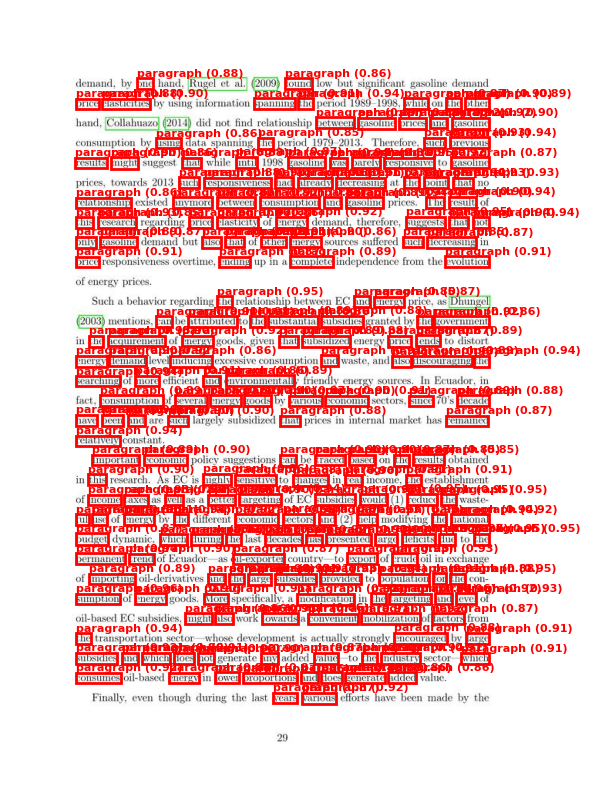

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pathlib import Path

# Set up base directory
dataset_dir = Path('/content/drive/MyDrive/YOLO_v8')

# Define your class names
class_names = ['abstract', 'author', 'caption', 'equation', 'figure', 'footer',
               'list', 'paragraph', 'reference', 'section', 'table', 'title']

# Create the test dataset
test_dataset = DocBankDataset(
    images_dir=dataset_dir / "images/test",
    annotations_dir=dataset_dir / "transformed_labels/test",
    class_names=class_names,
    transforms=None
)


# Pick a test sample
num_samples = len(test_dataset)

idx = random.randint(0, num_samples - 1)
image, target = test_dataset[idx]
image = image.to(device)

# Run inference

modelCV.eval()
with torch.no_grad():
    prediction = modelCV([image])[0][0]
    print("Prediction keys:", prediction.keys())
    print("Num boxes:", len(prediction['boxes']))
    print("Scores:", prediction['scores'])


    #print(prediction)

# Move image to CPU for visualization
image_np = image.cpu().permute(1, 2, 0).numpy()

# Visualize predicted boxes
plt.figure(figsize=(10, 10))
plt.imshow(image_np)
ax = plt.gca()

# Draw predictions with confidence > 0.5
total = 0
for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
    if score >= 0.5:
        total += 1
        xmin, ymin, xmax, ymax = box.cpu()
        width, height = xmax - xmin, ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        label_name = class_names[label - 1]  # adjust for background
        ax.text(xmin, ymin - 2, f"{label_name} ({score:.2f})", color='red', fontsize=8, weight='bold')


print(f"Total: {total}")
plt.axis("off")
plt.show()



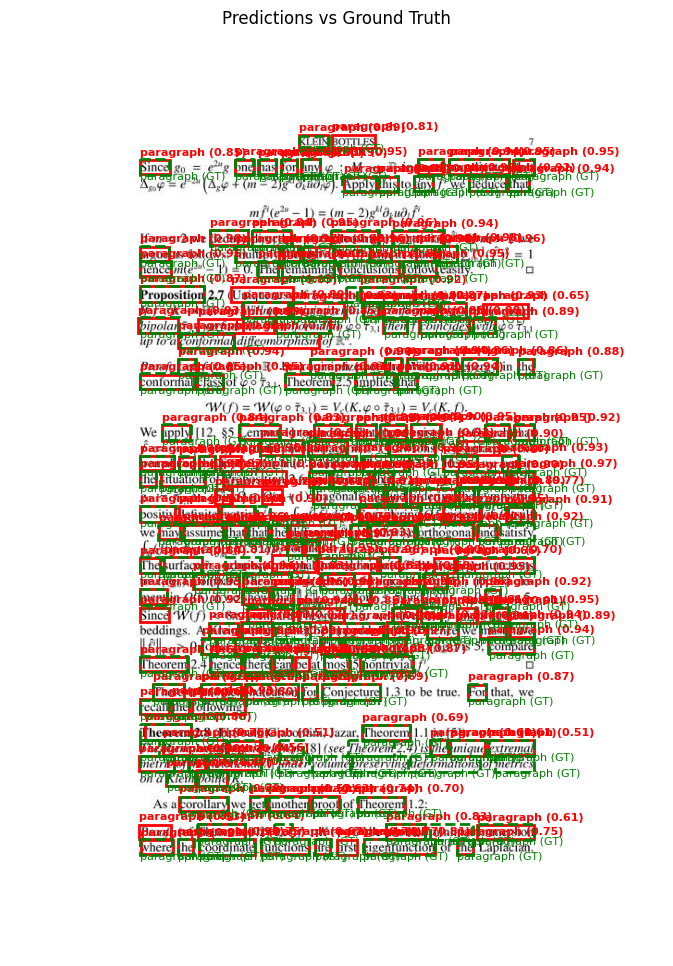

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms import ToTensor
from pathlib import Path
from PIL import Image

# Dataset location and classes
dataset_dir = Path('/content/drive/MyDrive/YOLO_v8')
class_names = ['abstract', 'author', 'caption', 'equation', 'figure', 'footer',
               'list', 'paragraph', 'reference', 'section', 'table', 'title']

# Load test dataset
test_dataset = DocBankDataset(
    images_dir=dataset_dir / "images/train",
    annotations_dir=dataset_dir / "transformed_labels/train",
    class_names=class_names,
    transforms=None  # We handle ToTensor manually
)

# Pick a test sample
image, target = test_dataset[idx]

# Convert to tensor if needed
if isinstance(image, Image.Image):
    image = ToTensor()(image)

image = image.to(device)

# Run inference
modelCV.eval()
with torch.no_grad():
    prediction = modelCV([image])[0]
    #prediction = prediction[0]

# Move image back to CPU for plotting
image_np = image.cpu().permute(1, 2, 0).numpy()

# Visualization
plt.figure(figsize=(12, 12))
plt.imshow(image_np)
ax = plt.gca()

#predicted boxes (in red)
for box, label, score in zip(prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']):
    if score > 0.5:
        xmin, ymin, xmax, ymax = box.cpu().numpy()
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        label_name = class_names[label - 1]
        ax.text(xmin, ymin - 5, f"{label_name} ({score:.2f})", color='red', fontsize=8, weight='bold')


#ground truth boxes (in green) OLD (4/07/25)

for box, label in zip(target['boxes'], target['labels']):
    xmin, ymin, xmax, ymax = box.cpu().numpy()
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=2, edgecolor='green', facecolor='none', linestyle='--')
    ax.add_patch(rect)
    label_name = class_names[label - 1]
    ax.text(xmin, ymax + 5, f"{label_name} (GT)", color='green', fontsize=8)

#Correction with scaling (4/7/25)
# --- Ground truth boxes (in green) with scaling ---
'''
original_width = 1000
original_height = 1000
#image_width, image_height = image.size  # PIL image
image_height, image_width = image_np.shape[:2]


x_scale = image_width / original_width
y_scale = image_height / original_height

for box, label in zip(target['boxes'], target['labels']):
    xmin, ymin, xmax, ymax = box.cpu().numpy()

    # Scale the GT box coordinates
    xmin_scaled = xmin * x_scale
    xmax_scaled = xmax * x_scale
    ymin_scaled = ymin * y_scale
    ymax_scaled = ymax * y_scale

    rect = patches.Rectangle((xmin_scaled, ymin_scaled), xmax_scaled - xmin_scaled, ymax_scaled - ymin_scaled,
                             linewidth=2, edgecolor='green', facecolor='none', linestyle='--')
    ax.add_patch(rect)
    label_name = class_names[label - 1]
    ax.text(xmin_scaled, ymax_scaled + 5, f"{label_name} (GT)", color='green', fontsize=8)
'''

plt.axis("off")
plt.title("Predictions vs Ground Truth")
plt.show()


### Metrics Evaluation

In [ ]:
def compute_iou(box1, box2):
    """
    box format: [xmin, ymin, xmax, ymax]
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)

    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = area1 + area2 - inter_area

    if union_area == 0:
        return 0
    return inter_area / union_area

In [ ]:
import torch
from torch.utils.data import DataLoader
import pandas as pd
from collections import Counter

print("Running evaluation on test dataset...")

# Build DataLoader for test
test_loader = DataLoader(
    test_dataset,
    batch_size=12,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

# Count ground truth and predicted labels
gt_counter = Counter()
pred_counter = Counter()
correct_counter = Counter()

modelCV.eval()
with torch.no_grad():
    for images, targets in test_loader:
        images_gpu = [img.to(device) for img in images]
        outputs = modelCV(images_gpu)

        if isinstance(outputs[0], list):
            outputs = outputs[0]

        for output, target in zip(outputs, targets):
            gt_boxes = target["boxes"].cpu().numpy()
            gt_labels = target["labels"].cpu().numpy().tolist()

            pred_boxes = output["boxes"].cpu().numpy()
            pred_labels = output["labels"].cpu().numpy().tolist()

            gt_counter.update(gt_labels)
            pred_counter.update(pred_labels)

            # For each predicted box, see if it matches any GT box of the same class with IoU > 0.5
            for pb, pl in zip(pred_boxes, pred_labels):
                for gb, gl in zip(gt_boxes, gt_labels):
                    if pl == gl:
                        iou_value = compute_iou(pb, gb)
                        if iou_value >= 0.5:
                            correct_counter[pl] += 1
                            break

# Build dataframe
results = []
for cls_id in range(1, len(class_names)+1):
    gt_count = gt_counter[cls_id]
    pred_count = pred_counter[cls_id]
    correct = correct_counter[cls_id]

    precision = correct / pred_count if pred_count > 0 else 0.0
    recall = correct / gt_count if gt_count > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision+recall) > 0 else 0.0

    results.append({
        "class_id": cls_id,
        "class_name": class_names[cls_id-1],
        "gt_count": gt_count,
        "pred_count": pred_count,
        "correct": correct,
        "precision": precision,
        "recall": recall,
        "f1": f1
    })

results_df = pd.DataFrame(results)

print("\n--- Approximate detection summary ---")
print(results_df[["class_name", "gt_count", "pred_count", "correct", "precision", "recall", "f1"]])

# ------------------------------------------------------------
# ✅ Compute global metrics
total_correct = sum(correct_counter.values())
total_pred = sum(pred_counter.values())
total_gt = sum(gt_counter.values())

micro_precision = total_correct / total_pred if total_pred > 0 else 0.0
micro_recall = total_correct / total_gt if total_gt > 0 else 0.0
micro_f1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0.0

macro_precision = results_df["precision"].mean()
macro_recall = results_df["recall"].mean()
macro_f1 = results_df["f1"].mean()
# ------------------------------------------------------------

Running evaluation on test dataset...

--- Approximate detection summary ---
   class_name  gt_count  pred_count  correct  precision  recall   f1
0    abstract     19852       19852    19852        1.0     1.0  1.0
1      author      2280        2280     2280        1.0     1.0  1.0
2     caption     30451       30451    30451        1.0     1.0  1.0
3    equation      2974        2974     2974        1.0     1.0  1.0
4      figure         0           0        0        0.0     0.0  0.0
5      footer      5613        5613     5613        1.0     1.0  1.0
6        list     18243       18243    18243        1.0     1.0  1.0
7   paragraph    638098      638098   638098        1.0     1.0  1.0
8   reference     36529       36529    36529        1.0     1.0  1.0
9     section      6189        6189     6189        1.0     1.0  1.0
10      table      2513        2513     2513        1.0     1.0  1.0
11      title      1327        1327     1327        1.0     1.0  1.0

--- Global metrics ---
Mi

In [ ]:
print("\n--- Global metrics (IoU > 0.5) ---")
print(f"Micro precision: {micro_precision:.4f}")
print(f"Micro recall:    {micro_recall:.4f}")
print(f"Micro F1:        {micro_f1:.4f}")
print()
print(f"Macro precision: {macro_precision:.4f}")
print(f"Macro recall:    {macro_recall:.4f}")
print(f"Macro F1:        {macro_f1:.4f}")

# ✅ Log global metrics to W&B
wandb.log({
    "global_metrics/micro_precision": micro_precision,
    "global_metrics/micro_recall": micro_recall,
    "global_metrics/micro_f1": micro_f1,
    "global_metrics/macro_precision": macro_precision,
    "global_metrics/macro_recall": macro_recall,
    "global_metrics/macro_f1": macro_f1
})

# ✅ Log individual per-class metrics
for idx, row in results_df.iterrows():
    wandb.log({
        f"quick_eval/{row['class_name']}/precision": row["precision"],
        f"quick_eval/{row['class_name']}/recall": row["recall"],
        f"quick_eval/{row['class_name']}/f1": row["f1"],
    })

# ✅ Log W&B table
print("Logging table to W&B...")
wandb_table = wandb.Table(dataframe=results_df)
wandb.log({"class_metrics_table": wandb_table})

print("\nEvaluation complete.")


--- Global metrics (IoU > 0.5) ---
Micro precision: 0.7289
Micro recall:    0.6101
Micro F1:        0.6642

Macro precision: 0.2934
Macro recall:    0.2384
Macro F1:        0.2430
Logging table to W&B...

Evaluation complete.


## 6. Finish project

In [ ]:
wandb.finish()